The code in this notebook is from this file: https://github.com/fwillett/speechBCI/blob/main/AnalysisExamples/naiveBayesClassification.ipynb

File contents have been edited to remove the phoneme and orofacial movement elements, as I do not use them. 

Data is pre-processed into a (1000, 256) array of 50 words x 20 trials per word and channel data where indexes [0,127] are -4.5xRMS threshold crossings and [128,255] are binned spike band power for those channels, with 20ms bins. These are then z-score normalized such that data[trialNum, channelNum] = z-score for that channel across that trial, with each trial being 1000ms (50 bins).

This data is used to train a Gaussian Naive Bayes Classifier, and a confusion matrix is created. Average accuracy is 94.1% and accuracy never drops below 75% for any word. This shows that the neural representations for words are very separable with the assumption that the data is Gaussian.

In [1]:
baseDir = "/Users/apple/Documents/MATLAB/EE 675/Willett Data/tuning-tasks-all/" # adjust to your directory
import scipy.io

fiftyWordDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.05.03_fiftyWordSet.mat')

In [11]:
import numpy as np

fiftyWordDat['feat'] = np.concatenate([fiftyWordDat['tx2'][:,0:128].astype(np.float32), fiftyWordDat['spikePow'][:,0:128].astype(np.float32)], axis=1)
fiftyWordDat['feat'] = np.sqrt(fiftyWordDat['feat'])

In [ ]:
#mean-subtract within block
import numpy as np
def meanSubtract(dat):
    dat['feat'] = np.concatenate([dat['tx2'][:,0:128].astype(np.float32), dat['spikePow'][:,0:128].astype(np.float32)], axis=1)
    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['feat'][loopIdx,:] -= np.mean(dat['feat'][loopIdx,:],axis=0,keepdims=True)
    return dat

#mean subtraction
fiftyWordDat = meanSubtract(fiftyWordDat)

In [42]:
from wordsOnlyAnalysis import triggeredAvg

fAvg_fiftyWord, fCI_fiftyWord, trials_fiftyWord = triggeredAvg(fiftyWordDat['feat'].astype(np.float32), 
                         fiftyWordDat['goTrialEpochs'][:,0],
                         np.squeeze(fiftyWordDat['trialCues']), [-50,50], smoothSD=4)

In [43]:
from wordsOnlyAnalysis import gnb_loo, bootCI

def plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx, title, figName):
    #confusion matrices
    codeList = np.unique(unroll_y)
    nCodes = len(codeList)
    cMat = np.zeros([nCodes, nCodes])

    for x in range(nCodes):
        for y in range(nCodes):
            thisSum = np.sum(np.logical_and(unroll_y==codeList[orderIdx[x]], y_pred==codeList[orderIdx[y]]))
            cMat[x,y] = thisSum

    for x in range(nCodes):
        cMat[x,:] = cMat[x,:] / np.sum(cMat[x,:])    
        
    import matplotlib.pyplot as plt
    from wordsOnlyAnalysis import plotPreamble
    plotPreamble()

    plt.figure(figsize=(5,5), dpi=300)
    plt.imshow(cMat,clim=[0,1])

    reorderLabels = []
    for x in range(len(tickLabels)):
        reorderLabels.append(tickLabels[orderIdx[x]])
        
    plt.xticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(title)

    plt.show()

In [44]:
#classify amongst all conditions EXCEPT "do nothing"
fiftyWordCuesToUse = np.arange(1,51).astype(np.int32)

In [45]:
trials_fiftyWord_subset = []
for t in range(len(fiftyWordCuesToUse)):
    trials_fiftyWord_subset.append(trials_fiftyWord[fiftyWordCuesToUse[t]])

In [46]:
y_pred, unroll_y = gnb_loo(trials_fiftyWord_subset, [50,100], np.arange(0,256).astype(np.int32))
print(np.mean(y_pred==unroll_y))
print(bootCI(y_pred, unroll_y)) # confidence interval (2.5-th and 97.5-th percentile in accuracy between pred and label)

0.848
[0.825 0.87 ]


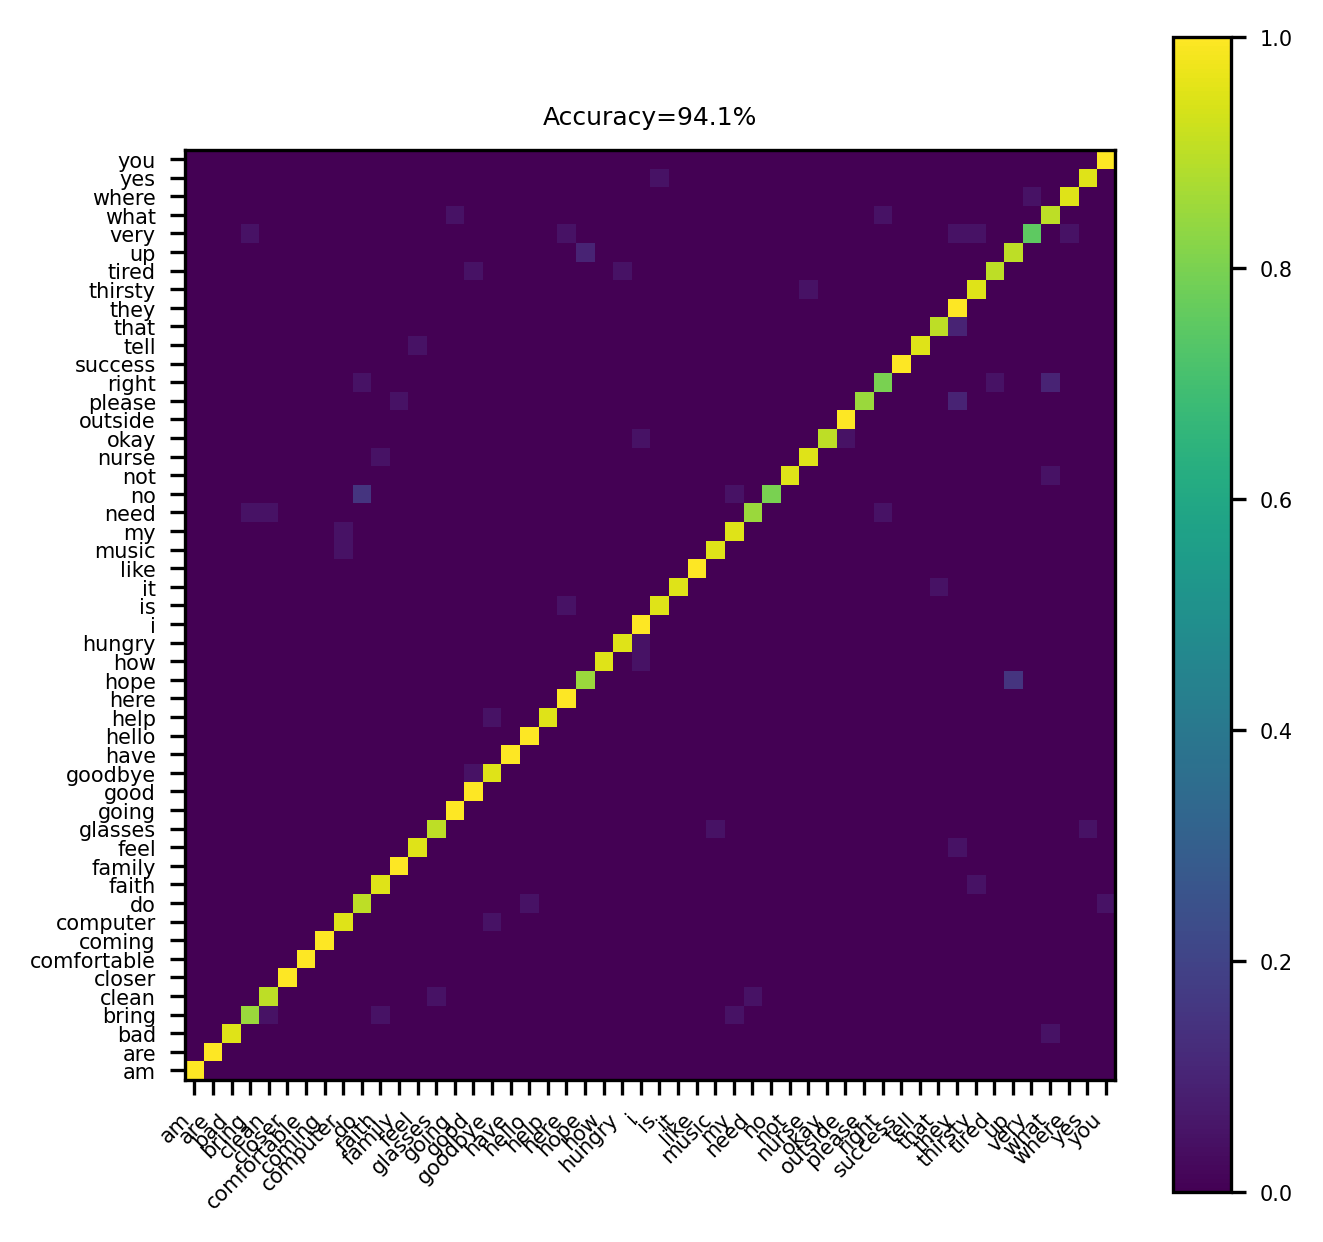

In [25]:
tickLabels = fiftyWordDat['cueList'][0,1:51]
fixedLabels = []
for x in range(len(tickLabels)):
    fixedLabels.append(tickLabels[x][0])
    
orderIdx = np.arange(0,50).astype(np.int32)
plotConfusionMatrix(unroll_y, y_pred, fixedLabels, orderIdx, 
                    'Accuracy='+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%', 
                    'fiftyWordConfusionMatrix_6v')

The code from now on is mine; first, I apply LDA to this data.

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [47]:
# normalize data and prepare it to be split into train/test sets

def normalize(trials_input = trials_fiftyWord_subset, timeWindow=[50,100], chanIdx = np.arange(0,256).astype(np.int32)):

    unroll_Feat = []
    for t in range(len(trials_input)):
        for x in range(trials_input[t].shape[0]):
            unroll_Feat.append(trials_input[t][x,:,:])

    unroll_Feat = np.concatenate(unroll_Feat, axis=0) # 1000 by 256 array of bins by channels
    # mn = np.mean(unroll_Feat, axis=0) # (256,) array of channel-wise averages -- used solely to z-score normalize below
    mn = np.zeros(256)
    # sd = np.std(unroll_Feat, axis=0)
    sd = np.ones(256)

    normalizedObs = []
    realLabels = []

    for t in range(len(trials_input)):
        for x in range(trials_input[t].shape[0]):
            tmp = (trials_input[t][x,:,:] - mn[np.newaxis,:])/sd[np.newaxis,:]
            b1 = np.mean(tmp[timeWindow[0]:timeWindow[1],chanIdx], axis=0) # channel-wise avg over bins 0-50            

            normalizedObs.append(b1) 
            realLabels.append(t)

    normalizedObs = np.stack(normalizedObs, axis=0) # 1000 by 256 array - each data point is an avg of bins 0-50 after go trial begins
    realLabels = np.array(realLabels).astype(np.int32) # 1000 array

    return normalizedObs, realLabels

X, y = normalize()

In [48]:
# Train and test on Tuning data

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)): # skf automatically balances classes in train/test splits
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    lda.fit(X_train, y_train)
    
    pred = lda.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracies.append(acc)
    
    print(f"Fold {fold+1} Accuracy: {acc*100:.1f}%")

print("\nChance Level: 2%")
print(f"\nAverage Accuracy: {np.mean(accuracies)*100:.1f}%") # Achieves 98.5% with 5 folds, 98% with 2 folds

Fold 1 Accuracy: 97.5%
Fold 2 Accuracy: 99.0%
Fold 3 Accuracy: 98.0%
Fold 4 Accuracy: 100.0%
Fold 5 Accuracy: 97.0%

Chance Level: 2%

Average Accuracy: 98.3%


Testing the trained LDA on other days' data - extract Yes/No data from May 17th & May 19th.

In [44]:
baseDir2 = "/Users/apple/Documents/MATLAB/EE 675/Willett Data/sentences/"

compDat1 = scipy.io.loadmat(baseDir2+'t12.2022.05.17_sentences.mat') # data from May 17th 2022
compDat2 = scipy.io.loadmat(baseDir2+'t12.2022.05.19_sentences.mat') # data from May 19th 2022

In [45]:
def meanSubtract2(dat):
    dat['feat'] = np.concatenate([dat['tx2'][:,0:128].astype(np.float32), dat['spikePow'][:,0:128].astype(np.float32)], axis=1)
        
    blockList = dat['blockList'][np.where(dat['blockTypes'] == 'OL Chang')[0]]
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['feat'][loopIdx,:] -= np.mean(dat['feat'][loopIdx,:],axis=0,keepdims=True)
    return dat, blockList

changDat, blockList = meanSubtract2(compDat1)

In [46]:
def changSentences(data, blockList):
    sentences = []
    binRange = []
    for block in blockList:
        rangeTemp = np.where(data['blockNum'] == block)[0]
        trialMin = np.where(data['goTrialEpochs'] == rangeTemp[0])[0][0] + 1
        trialMax = np.where(data['goTrialEpochs'] == rangeTemp[-1] + 1)[0][0]
        sentences.append(data['sentences'][trialMin:trialMax + 1])
        binRange.append(data['goTrialEpochs'][trialMin:trialMax + 1])
    return np.concatenate(np.squeeze(sentences)), np.concatenate(binRange)

In [47]:
def normalizeYesNo(data):
    changDatTemp, blockList = meanSubtract2(data)
    sentenceList, binRange = changSentences(changDatTemp, blockList)

    noId = np.where(sentenceList == "No")[0].item()
    yesId = np.where(sentenceList == "Yes")[0].item()

    noData = data['feat'][binRange[noId, 0]:binRange[noId, 1], :]
    yesData = data['feat'][binRange[yesId, 0]:binRange[yesId, 1], :]

    noMean, noStd = np.mean(noData, axis=0), np.std(noData, axis=0)
    yesMean, yesStd = np.mean(yesData, axis=0), np.std(yesData, axis=0)

    for channel in yesStd:
        if channel == 0:
            yesStd[np.where(yesStd == 0)] = 0.0001

    # normalization leads to LDA predicting the same label for all data for some reason; hence it is omitted
    # noData = (noData - noMean[np.newaxis, :])/noStd[np.newaxis, :] # z-score normalize
    # yesData = (yesData - yesMean[np.newaxis, :])/yesStd[np.newaxis, :]

    return np.mean(noData[:], axis=0), np.mean(yesData[:], axis=0)


In [48]:
# Test on other days' data

noData1, yesData1 = normalizeYesNo(compDat1)
noData2, yesData2 = normalizeYesNo(compDat2)

predList = []
pred = lda.predict([noData1, noData2, yesData1, yesData2])
for word in pred:
    predList.append(fiftyWordDat['cueList'][0][1:][word].item())
print(predList) # see what it predicts for "no", "no", "yes", "yes" - it should get them all wrong; chance level is still 2%

['you', 'you', 'have', 'nurse']


Train new LDA on the Yes/No data from the Tuning Tasks, test on May 17th and 19th data.

In [49]:
# sqrt transform -- makes spike bins look more gaussian; use only the ventral array, which was found to contain more information about speech. This is a manual dimensionality-reduction step necessitated by my lack of data.
fiftyWordDat['feat'] = np.concatenate([fiftyWordDat['tx2'][:,:32].astype(np.float32), fiftyWordDat['tx2'][:,96:128].astype(np.float32), fiftyWordDat['spikePow'][:,:32].astype(np.float32), fiftyWordDat['spikePow'][:,96:128].astype(np.float32)], axis=1)
fiftyWordDat['feat'] = np.sqrt(fiftyWordDat['feat'])

# collect the bins for yes and no trials

yesIdx = np.where(fiftyWordDat['cueList'] == 'yes')[1][0]
noIdx = np.where(fiftyWordDat['cueList'] == 'no')[1][0]

noTrials = np.where(fiftyWordDat['trialCues'] == noIdx)[0]
yesTrials = np.where(fiftyWordDat['trialCues'] == yesIdx)[0]

noTrialEpochs = [fiftyWordDat['goTrialEpochs'][trialNum] for trialNum in noTrials]
yesTrialEpochs = [fiftyWordDat['goTrialEpochs'][trialNum] for trialNum in yesTrials]

noTrialBins = [np.mean(fiftyWordDat['feat'][epoch[1] - 50:epoch[1]], axis=0) for epoch in noTrialEpochs] # the last 50 bins were found to be the most informative
yesTrialBins = [np.mean(fiftyWordDat['feat'][epoch[1] - 50:epoch[1]], axis=0) for epoch in yesTrialEpochs] # (20, 50, 256) 

yesNoData = np.concatenate((noTrialBins, yesTrialBins))
yesNoLabels = np.concatenate((np.zeros(20),np.ones(20)))

In [50]:
# keep ventral array data only -- see the README files in the datasets for electrode indices that correspond to the ventral array
def adjustData(data):
    return np.concatenate((data[:32], data[96:128], data[128:160], data[224:]))
noData1, yesData1 = adjustData(noData1), adjustData(yesData1)
noData2, yesData2 = adjustData(noData2), adjustData(yesData2)

In [51]:
# Train and test on Tuning data

skfYesNo = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ldaYesNo = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

accuracies = []

for fold, (train_idx, test_idx) in enumerate(skfYesNo.split(yesNoData, yesNoLabels)): # skf automatically balances classes in train/test splits
    X_train, X_test = yesNoData[train_idx], yesNoData[test_idx]
    y_train, y_test = yesNoLabels[train_idx], yesNoLabels[test_idx]
    
    ldaYesNo.fit(X_train, y_train)
    
    pred = ldaYesNo.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracies.append(acc)
    
    print(f"Fold {fold+1} Accuracy: {acc*100:.1f}%")

print("\nChance Level: 50%")
print(f"\nAverage Accuracy: {np.mean(accuracies)*100:.1f}%") # Achieves 97.5% with 5 folds and 2 folds

Fold 1 Accuracy: 87.5%
Fold 2 Accuracy: 100.0%
Fold 3 Accuracy: 100.0%
Fold 4 Accuracy: 100.0%
Fold 5 Accuracy: 100.0%

Chance Level: 50%

Average Accuracy: 97.5%


In [52]:
# Test on other days' data

yesNoDict = {
    0: "no",
    1: "yes"
}

predList = []
pred = ldaYesNo.predict([noData1, noData2, yesData1, yesData2])

for word in pred:
    predList.append(yesNoDict[int(word)])
print(predList) # see what it predicts for "no", "no", "yes", "yes" - it should get chance level, which is now at 50%

['yes', 'no', 'yes', 'no']
